In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
import matplotlib.pyplot as plt
import copy
import math

In [2]:
pd.set_option('display.max_columns',None)

# Import Data

### Table 1: Subscribers

In [3]:
df_sub = pd.read_csv("subscribers.csv")

In [4]:
df_sub.shape

(227628, 31)

### Table 2: Engagement

In [5]:
df_en = pd.read_pickle("engagement")

In [6]:
df_en.shape

(2585724, 9)

### Table 3: Customer Service Reps

In [7]:
df_rep = pd.read_pickle("customer_service_reps")

In [8]:
df_rep.shape

(2208643, 13)

### Table 4: Ad Channel

In [9]:
df_ad = pd.read_csv("channel_spend_graduate.csv")

In [10]:
df_ad.shape

(40, 3)

# Attribution and Allocation

### Attribution Technical

In [11]:
# Create Channel List
df_channel = df_ad.pivot_table(values = 'spend_AED', columns = 'date', index = 'channel', aggfunc = np.sum)
df_channel

date,201907,201908,201909,201910,201911,201912,202001,202002
channel,,,,,,,,
bing,400,900,1000,1100,1300,300,2100,3700
display,12,20,13,19,29,31,148,94
facebook,9000,13000,10500,17000,23000,16000,11000,14000
search,13000,18500,19000,24000,25000,38000,41000,44000
youtube,90,180,100,130,550,900,4360,2420


In [12]:
# Create Attribution Dataframe for Subs
channel_list = df_channel.index.tolist()
channel_list

['bing', 'display', 'facebook', 'search', 'youtube']

In [13]:
df_sub_new = df_sub[df_sub['attribution_technical'].isin(channel_list)]

In [14]:
df_sub_new.shape

(109023, 31)

In [15]:
df_sub_new['attribution_technical'].value_counts()

facebook    80251
search      25306
display      1407
bing         1146
youtube       913
Name: attribution_technical, dtype: int64

In [16]:
# Create Attribution Dataframe for Reps
sub_list = df_sub_new.subid.tolist()

In [17]:
df_rep_new = df_rep[df_rep['subid'].isin(sub_list)]

In [18]:
df_rep_new.shape

(96154, 13)

In [19]:
# df_rep is incomplete as the subid in it is smaller than that in df_sub.

In [20]:
# Revenue: Payment Period (X-1) * month price + join fee 

In [21]:
df_sub_new.join_fee = df_sub_new.join_fee.fillna(0)
df_sub_new['join_fee'][df_sub_new.join_fee < 0] = 0

/Users/jishuoo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-21-6d8492e3dd55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_new['join_fee'][df_sub_new.join_fee < 0] = 0
/Users/jishuoo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [22]:
df_sub_new.loc[df_sub_new['payment_period']==0, 'Total_Revenue'] = df_sub_new['join_fee']

/Users/jishuoo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/jishuoo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [23]:
df_sub_new.loc[df_sub_new['payment_period']!=0, 'Total_Revenue'] = df_sub_new['join_fee'] + df_sub_new['monthly_price'] * 4 * (df_sub_new['payment_period'])

/Users/jishuoo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [24]:
df1 = pd.DataFrame(df_sub_new.groupby('attribution_technical')['Total_Revenue'].sum())
df2 = pd.DataFrame(df_sub_new.groupby('attribution_technical')['subid'].count())
df3 = pd.DataFrame(df_ad.groupby('channel')['spend_AED'].sum())
df4 = pd.DataFrame(df_sub_new.groupby('attribution_technical')['payment_period'].mean())

In [25]:
df_sub_new['attribution_technical'].value_counts()

facebook    80251
search      25306
display      1407
bing         1146
youtube       913
Name: attribution_technical, dtype: int64

In [26]:
frame = [df1,df2,df3,df4]
df5 = pd.concat(frame,axis = 1)
df5

,Total_Revenue,subid,spend_AED,payment_period
bing,1.451804e+04,1146,10800,0.658813
display,1.628963e+04,1407,366,0.599858
facebook,1.149965e+06,80251,113500,0.751368
search,4.057859e+05,25306,222500,0.839524
youtube,1.289432e+04,913,8730,0.736035


In [27]:
df5['CAC'] = df5['spend_AED']/df5['subid']
df5

,Total_Revenue,subid,spend_AED,payment_period,CAC
bing,1.451804e+04,1146,10800,0.658813,9.424084
display,1.628963e+04,1407,366,0.599858,0.260128
facebook,1.149965e+06,80251,113500,0.751368,1.414313
search,4.057859e+05,25306,222500,0.839524,8.792381
youtube,1.289432e+04,913,8730,0.736035,9.561884


In [28]:
df5['LTV'] = df5['Total_Revenue']/df5['subid']
df5

,Total_Revenue,subid,spend_AED,payment_period,CAC,LTV
bing,1.451804e+04,1146,10800,0.658813,9.424084,12.668449
display,1.628963e+04,1407,366,0.599858,0.260128,11.577559
facebook,1.149965e+06,80251,113500,0.751368,1.414313,14.329604
search,4.057859e+05,25306,222500,0.839524,8.792381,16.035166
youtube,1.289432e+04,913,8730,0.736035,9.561884,14.123028


In [29]:
df5['ROI'] = df5['LTV']/df5['CAC']
df5.to_excel('df5.xlsx')

# A/B Testing

Total Revenue

In [30]:
df_sub.join_fee = df_sub.join_fee.fillna(0)
df_sub['join_fee'][df_sub.join_fee < 0] = 0
df_sub.loc[df_sub['payment_period']==0, 'Total_Revenue'] = df_sub['join_fee']
df_sub.loc[df_sub['payment_period']!=0, 'Total_Revenue'] = df_sub['join_fee'] + df_sub['monthly_price'] * 4 * (df_sub['payment_period']-1)

<ipython-input-30-3730f8f2e67a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['join_fee'][df_sub.join_fee < 0] = 0


In [31]:
df_sub.head()

,Unnamed: 0,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,country,attribution_technical,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,trial_end_date,initial_credit_card_declined,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed,Total_Revenue
0,162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,UAE,facebook,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-24 21:44:16,2020-02-07 21:44:16,False,0.0000,ar,Standard Charter,14,True,1,2020-02-07 21:44:16,2020-06-07 21:44:16,NaN,True,0.0000
1,380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,UAE,facebook,facebook,NaN,4,base_uae_14_day_trial,4.7343,4.5141,2020-03-01 15:44:35,2020-03-15 15:44:35,False,0.3303,ar,NaN,14,True,1,2020-03-15 15:44:35,2020-07-15 15:44:35,NaN,True,0.3303
2,496617,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,UAE,organic,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-07 16:37:06,2019-12-21 16:37:06,False,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True,0.1101
3,356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,UAE,search,tv,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-27 16:09:32,2020-02-10 16:09:32,False,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True,0.0367
4,681701,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,UAE,discovery,youtube,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-10-05 12:57:07,2019-10-19 12:57:07,False,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,True,18.9739


In [32]:
df_sub['plan_type'].value_counts()

base_uae_14_day_trial                227096
high_uae_14_day_trial                   325
low_uae_no_trial                        167
base_eur_14_day_trial                    18
high_sar_14_day_trial                    12
low_gbp_14_day_trial                      4
high_aud_14_day_trial                     2
high_jpy_14_day_trial                     1
low_sar_no_trial                          1
low_eur_no_trial                          1
base_uae_no_trial_7_day_guarantee         1
Name: plan_type, dtype: int64

In [33]:
base_grp = ['base_eur_14_day_trial','base_uae_14_day_trial']
high_grp = ['high_uae_14_day_trial','high_sar_14_day_trial','high_jpy_14_day_trial']

In [34]:
df_sub.loc[df_sub['plan_type'].isin(base_grp),'Group'] = 'A'
df_sub.loc[df_sub['plan_type'].isin(high_grp),'Group'] = 'B'

In [35]:
df_sub['Group'].value_counts()

A    227114
B       338
Name: Group, dtype: int64

In [36]:
df_sub[df_sub['Group']=='A']['payment_period'].value_counts()

0    95188
1    86895
2    42712
3     2319
Name: payment_period, dtype: int64

In [37]:
import scipy.stats as stats 
import statsmodels.stats.api as sms 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns 
from math import ceil 

In [38]:
effect_size = sms.proportion_effectsize(0.20, 0.30) # 根据我们的预期比率计算效应量

In [39]:
required_n = sms.NormalIndPower().solve_power( 
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1 
    ) # 计算需要的样本量
print(required_n)

required_n = 292

291.6886683175625


In [40]:
control_sample = df_sub[df_sub['Group'] == 'A'].sample(n=required_n, random_state=22) 
treatment_sample = df_sub[df_sub['Group'] == 'B'].sample(n=required_n, random_state=22) 

In [41]:
ab_test = pd.concat([control_sample,treatment_sample],axis=0) 
ab_test.reset_index(drop=True, inplace=True)

In [42]:
ab_test.head()

,Unnamed: 0,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,country,attribution_technical,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,trial_end_date,initial_credit_card_declined,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed,Total_Revenue,Group
0,494972,26958990,economy,2.0,comedy,access to exclusive content,24.401536,2.0,55.0,False,UAE,brand sem intent google,tv,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-02-06 04:16:35,2020-02-20 04:16:35,False,0.6606,ar,NaN,14,False,0,NaN,NaN,2020-02-13 00:00:00,False,0.6606,A
1,427663,27134652,economy,3.0,drama,supplement OTT,21.501623,2.0,63.0,False,UAE,email,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-11-18 11:44:29,2019-12-02 11:44:29,False,0.0000,ar,NaN,14,False,0,NaN,NaN,NaN,True,0.0000,A
2,603893,28393424,enhanced,NaN,comedy,replace OTT,24.401536,NaN,58.0,False,UAE,facebook,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-17 12:28:00,2019-12-31 12:28:00,False,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True,0.0367,A
3,146407,23069019,enhanced,2.0,drama,access to exclusive content,20.051667,2.0,52.0,False,UAE,facebook,referral,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-11-24 06:02:55,2019-12-08 06:02:55,False,0.0367,ar,Paypal,14,True,1,2019-12-08 06:02:55,2020-04-08 06:02:55,NaN,True,0.0367,A
4,346146,27425037,base,3.0,comedy,access to exclusive content,31.651317,2.0,51.0,False,UAE,email,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2019-08-16 13:05:28,2019-08-30 13:05:28,False,0.0000,ar,NaN,14,True,2,2019-12-30 13:05:28,2020-04-30 13:05:28,NaN,True,18.9372,A


Total Revenue

In [43]:
total_revenue = ab_test.groupby('Group')['Total_Revenue'] 

std_p = lambda x: np.std(x, ddof=0) # Std. 比例偏差
se_p = lambda x: stats.sem(x, ddof=0) # Std. 比例误差 (std / sqrt(n)) 

total_revenue = total_revenue.agg([np.mean, std_p, se_p]) 
total_revenue.columns = ['total_revenue', 'std_deviation', 'std_error'] 


total_revenue.style.format ('{:.3f}')

,total_revenue,std_deviation,std_error
Group,,,
A,3.855,7.999,0.468
B,10.916,10.164,0.595


In [44]:
import seaborn as sns

In [45]:
import statsmodels.stats.weightstats as st

In [46]:
control_revenue = control_sample[['Group','Total_Revenue']]
treat_revenue = treatment_sample[['Group','Total_Revenue']]

/Users/jishuoo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


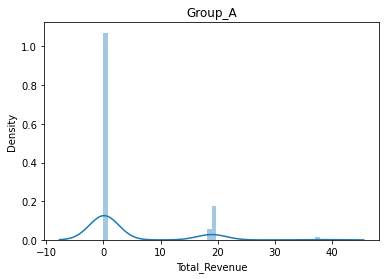

/Users/jishuoo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


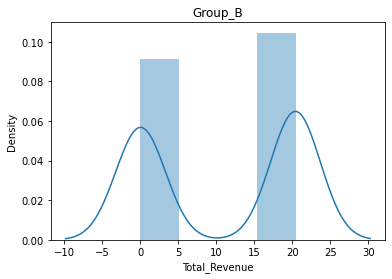

In [47]:
#查看数据集分布
sns.distplot(control_revenue['Total_Revenue'])
plt.title('Group_A')
plt.show()

sns.distplot(treat_revenue['Total_Revenue'])
plt.title('Group_B')
plt.show()

In [48]:
control_revenue.dropna(inplace=True)
treat_revenue.dropna(inplace=True)

<ipython-input-48-0f11238987c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_revenue.dropna(inplace=True)
<ipython-input-48-0f11238987c0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_revenue.dropna(inplace=True)


In [49]:
t,p_two,df = st.ttest_ind(control_revenue['Total_Revenue'],treat_revenue['Total_Revenue'],usevar='unequal')
print('t=',t,'p_twoTail=',p_two,',df=',df)

t= -9.31284395299473 p_twoTail= 2.94019035695214e-19 ,df= 551.5142067488948


In [50]:
alpha = 0.05
if(p_two< alpha/2): 
    print('Reject H0')
else: 
    print('Accept H0')

Reject H0


Payment Period

In [51]:
payment = ab_test.groupby('Group')['payment_period'] 

std_p = lambda x: np.std(x, ddof=0) # Std. 比例偏差
se_p = lambda x: stats.sem(x, ddof=0) # Std. 比例误差 (std / sqrt(n)) 

payment = payment.agg([np.mean, std_p, se_p]) 
payment.columns = ['payment_period', 'std_deviation', 'std_error'] 


payment.style.format ('{:.3f}')

,payment_period,std_deviation,std_error
Group,,,
A,0.753,0.777,0.045
B,1.178,0.927,0.054


In [52]:
control_payment = control_sample[['Group','payment_period']]
treat_payment = treatment_sample[['Group','payment_period']]

/Users/jishuoo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


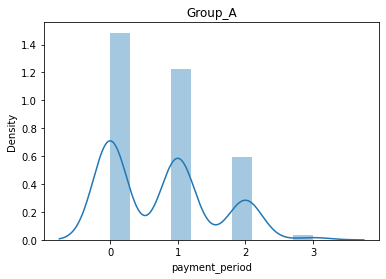

/Users/jishuoo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


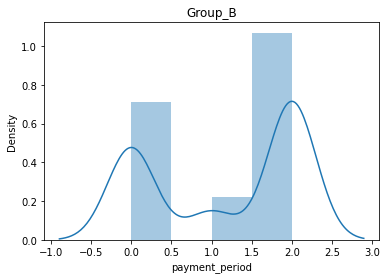

In [53]:
#查看数据集分布
sns.distplot(control_payment['payment_period'])
plt.title('Group_A')
plt.show()

sns.distplot(treat_payment['payment_period'])
plt.title('Group_B')
plt.show()

In [54]:
treat_payment.dropna(inplace=True)
control_payment.dropna(inplace=True)

<ipython-input-54-d1794543138d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_payment.dropna(inplace=True)
<ipython-input-54-d1794543138d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_payment.dropna(inplace=True)


In [55]:
t,p_two,df = st.ttest_ind(treat_payment['payment_period'], control_payment['payment_period'],usevar='unequal')
print('t=',t,'p_twoTail=',p_two,',df=',df)

t= 5.990592560843116 p_twoTail= 3.7246765124578803e-09 ,df= 564.8087975530442


In [56]:
alpha = 0.05
if(p_two< alpha/2): 
    print('Reject H0')
else: 
    print('Accept H0')

Reject H0


Consumption Hour

In [57]:
hours = ab_test.groupby('Group')['weekly_consumption_hour'] 

std_p = lambda x: np.std(x, ddof=0) # Std. 比例偏差
se_p = lambda x: stats.sem(x, ddof=0) # Std. 比例误差 (std / sqrt(n)) 

hours = hours.agg([np.mean, std_p, se_p]) 
hours.columns = ['weekly_consumption_hours', 'std_deviation', 'std_error'] 


hours.style.format ('{:.3f}')

,weekly_consumption_hours,std_deviation,std_error
Group,,,
A,27.809,4.719,nan
B,27.427,4.563,nan


In [58]:
control_hours = control_sample[['Group','weekly_consumption_hour']]
treat_hours = treatment_sample[['Group','weekly_consumption_hour']]

/Users/jishuoo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


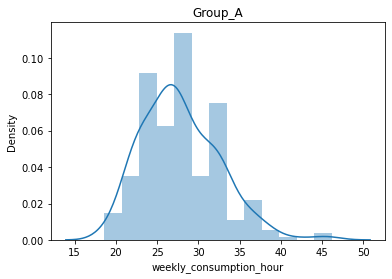

/Users/jishuoo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


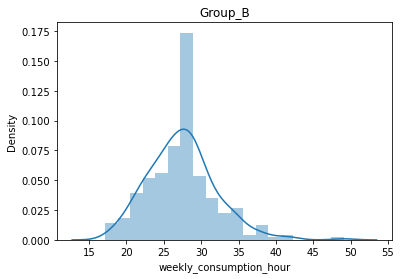

In [59]:
#查看数据集分布
sns.distplot(control_hours['weekly_consumption_hour'])
plt.title('Group_A')
plt.show()

sns.distplot(treat_hours['weekly_consumption_hour'])
plt.title('Group_B')
plt.show()

In [60]:
control_hours.dropna(inplace=True)
treat_hours.dropna(inplace=True)

<ipython-input-60-9a704d054ae7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_hours.dropna(inplace=True)
<ipython-input-60-9a704d054ae7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treat_hours.dropna(inplace=True)


In [61]:
t,p_two,df = st.ttest_ind(control_hours['weekly_consumption_hour'], treat_hours['weekly_consumption_hour'],usevar='unequal')
print('t=',t,'p_twoTail=',p_two,',df=',df)

t= 0.9560752691946799 p_twoTail= 0.33946894727250787 ,df= 531.3927161745277


In [62]:
alpha = 0.05
if(p_two< alpha/2): 
    print('Reject H0')
else: 
    print('Accept H0')

Accept H0


# Churn

In [63]:
df_sub = pd.read_csv("subscribers.csv")

In [64]:
df_un = df_en.groupby('subid').mean()

In [65]:
df_m = pd.merge(df_sub,df_un,on='subid')

In [66]:
df_m.pivot_table(values = 'subid', columns = 'current_sub_TF', index = 'trial_completed', aggfunc = lambda x: len(x.unique()))

current_sub_TF,False,True
trial_completed,,
False,15901,501
True,43030,75587


In [67]:
# Current_sub_TF = F & Trial_completed = F : Cancel before trial end
# Current_sub_TF = F & Trial_completed = T : Churn (lost)
# Current_sub_TF = T & Trial_completed = T : Current Customers
# Current_sub_TF = T & Trial_completed = F : Cancel before next payment - Churn (about to lose)

df_m.loc[(df_m['current_sub_TF'] == False) & (df_m['trial_completed'] == False), 'Churn_TF'] = 1
df_m.loc[(df_m['current_sub_TF'] == False) & (df_m['trial_completed'] == True), 'Churn_TF'] = 1
df_m.loc[(df_m['current_sub_TF'] == True) & (df_m['trial_completed'] == True), 'Churn_TF'] = 0
df_m.loc[(df_m['current_sub_TF'] == True) & (df_m['trial_completed'] == False), 'Churn_TF'] = 1

In [68]:
df_m.loc[(df_m['male_TF'] == False),'Gender'] = 0
df_m.loc[(df_m['male_TF'] == True),'Gender']  = 1

In [69]:
columns = ['num_weekly_services_utilized','weekly_consumption_hour','num_ideal_streaming_services','discount_price','join_fee','payment_period_x','app_opens','cust_service_mssgs','num_videos_completed','num_videos_more_than_30_seconds','num_videos_rated','num_series_started','payment_period_y','Churn_TF']

In [70]:
df_m = df_m[columns]

In [71]:
df_m.isna().sum()

num_weekly_services_utilized       54224
weekly_consumption_hour            24085
num_ideal_streaming_services       55435
discount_price                         0
join_fee                           22708
payment_period_x                       0
app_opens                              0
cust_service_mssgs                     0
num_videos_completed                   0
num_videos_more_than_30_seconds        0
num_videos_rated                       0
num_series_started                     0
payment_period_y                       0
Churn_TF                               0
dtype: int64

In [72]:
df_m.dropna(inplace=True)

In [73]:
df_m.drop(columns = "payment_period_y",inplace = True)

In [74]:
df_m['Churn_TF'].value_counts()

0.0    42714
1.0    36772
Name: Churn_TF, dtype: int64

In [75]:
df_m

,num_weekly_services_utilized,weekly_consumption_hour,num_ideal_streaming_services,discount_price,join_fee,payment_period_x,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,Churn_TF
0,3.0,36.001186,2.0,4.5141,0.1101,0,1.000000,1.000000,6.500000,6.500000,0.000000,0.500000,1.0
1,2.0,20.051667,2.0,4.5141,0.3303,1,0.975610,0.414634,4.439024,4.439024,0.146341,0.951220,0.0
2,3.0,34.551230,2.0,4.5141,0.0000,1,2.260870,0.217391,1.826087,4.478261,0.000000,0.630435,0.0
5,2.0,28.751405,2.0,4.5141,0.0367,0,2.400000,0.800000,3.600000,4.400000,0.000000,0.600000,1.0
6,3.0,33.101274,2.0,4.5141,0.0367,0,5.071429,0.428571,3.714286,4.857143,0.000000,0.857143,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135010,4.0,27.301448,2.0,4.5141,0.0000,1,1.000000,0.500000,1.500000,5.500000,0.000000,0.500000,0.0
135013,3.0,30.201361,2.0,4.5141,0.0000,2,1.500000,2.000000,6.000000,6.500000,0.000000,0.500000,0.0
135016,2.0,24.401536,2.0,4.5141,0.0000,1,2.583333,0.416667,3.916667,4.916667,0.000000,0.666667,0.0
135017,3.0,28.751405,2.0,4.5141,0.3303,1,1.777778,0.333333,2.222222,4.000000,0.000000,0.222222,0.0


In [76]:
# ----- SPLIT DATA -----
df_train, df_test = model_selection.train_test_split(df_m, test_size=0.3)

# ----- FIT CHURN MODEL ------
y_col_name = 'Churn_TF' # specify which column contains outcome variable y. Needs to be coded as binary True/False or 0/1
x_col_name =  ['num_weekly_services_utilized','weekly_consumption_hour','num_ideal_streaming_services','discount_price','join_fee','payment_period_x','app_opens','cust_service_mssgs','num_videos_completed','num_videos_more_than_30_seconds','num_videos_rated','num_series_started']
add_constant_TF = True

# --- preprocess data for model routine format requirements
if add_constant_TF:
    x_col_name.append('const')
    df_train = sm.add_constant(df_train)
    df_test = sm.add_constant(df_test)

In [77]:
# --- fit linear probability model
lpm_model = sm.OLS(endog=df_train[y_col_name], exog=df_train[x_col_name])
lpm_results = lpm_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(lpm_results.summary())


RESULTS OF LOGIT MODEL FITTING

                            OLS Regression Results                            
Dep. Variable:               Churn_TF   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     7036.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:16:15   Log-Likelihood:                -14548.
No. Observations:               55640   AIC:                         2.912e+04
Df Residuals:                   55627   BIC:                         2.924e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [78]:
# --- fit logistic regression
logit_model = sm.Logit(endog=df_train[y_col_name], exog=df_train[x_col_name])
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.264929
         Iterations 8

RESULTS OF LOGIT MODEL FITTING

                           Logit Regression Results                           
Dep. Variable:               Churn_TF   No. Observations:                55640
Model:                          Logit   Df Residuals:                    55627
Method:                           MLE   Df Model:                           12
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.6163
Time:                        20:16:15   Log-Likelihood:                -14741.
converged:                       True   LL-Null:                       -38420.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
num_weekly_services_utilized     

In [90]:

# ------ DEFINE FUNCTIONS -----
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['Churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['Churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['Churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance
    #上面这行不太好理解，其实就是虽然我们用accept_offer_prob来假设了接受offer的概率，但是在程序里机器没法直接用30%的概率来选人，我们要先随机生成random_draws（0到1区间内随机数），来判断这个人会不会接受offer，根据大数定理，最后接受offer的人数从整体来看会接近accept_offer_prob

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['prob_churn_lpm'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact


def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives




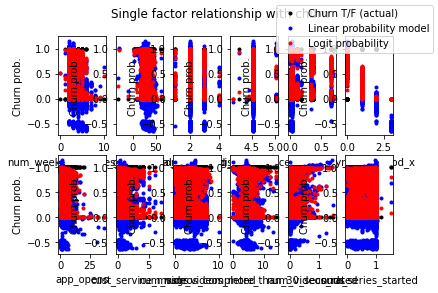

In [91]:
# ----- EVALUATE MODEL PERFORMANCE -----
# --- evaluate model predictions on test set graphically
df_test['prob_churn_lpm'] = lpm_results.predict(df_test[x_col_name])
df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name])

# plot predictions vs. data
select_plot_coef = [x for x in x_col_name if x != 'const']
n_rows = 2
n_cols = math.ceil(len(select_plot_coef) / n_rows)
fig, axes = plt.subplots(n_rows, n_cols)
fig.suptitle('Single factor relationship with churn')
for i in range(n_rows):
    for j in range(n_cols):
        select_coef = select_plot_coef[i * n_cols + j]
        axes[i, j].plot(df_test[select_coef], df_test['Churn_TF'], 'k.')
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_lpm'], 'b.')
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_logit'], 'r.')
        axes[i, j].set(xlabel=select_coef, ylabel='Churn prob.')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

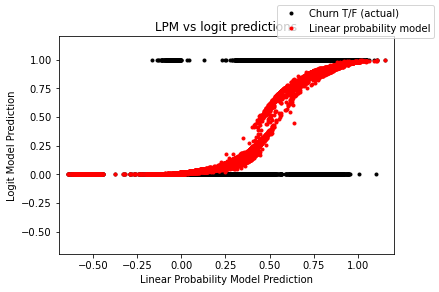

In [92]:
# compare lpm and logit predictions
fig = plt.figure()
ax = plt.gca()
ax.plot(df_test[['prob_churn_lpm']], df_test[['Churn_TF']], 'k.')
ax.plot(df_test[['prob_churn_lpm']], df_test[['prob_churn_logit']], 'r.')
plt.ylim(df_test[['prob_churn_lpm', 'prob_churn_logit']].min().min()-.05, df_test[['prob_churn_lpm', 'prob_churn_logit']].max().max()+.05)
plt.xlim(ax.get_ylim())
plt.title('LPM vs logit predictions')
plt.xlabel('Linear Probability Model Prediction')
plt.ylabel('Logit Model Prediction')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])


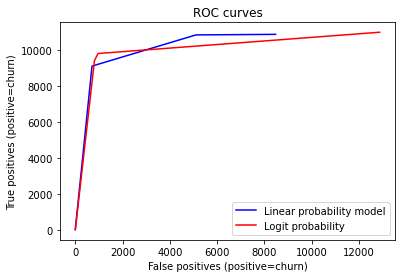

In [93]:

# --- evaluate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test['Churn_TF'], df_test['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df_test['Churn_TF'], df_test['prob_churn_lpm'])

# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, 'b-')
ax1.plot(logit_false_positives, logit_true_positives, 'r-')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

In [94]:
np.random.random(10)

array([0.74402547, 0.03316841, 0.20751576, 0.07488866, 0.11574709,
       0.53734485, 0.8943437 , 0.8461136 , 0.11496327, 0.76340141])

In [109]:

# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.4
threshold = 0.7
base_price = 4.7343
discount_amount = 0.3
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind


# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    acceptance_rate_churn = t_discount_amount/2
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind



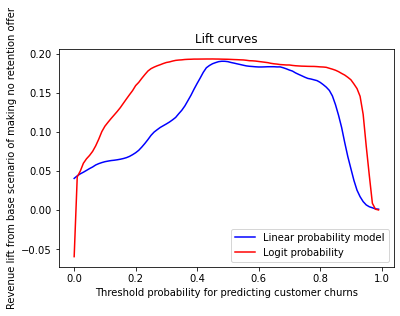

In [98]:

# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])



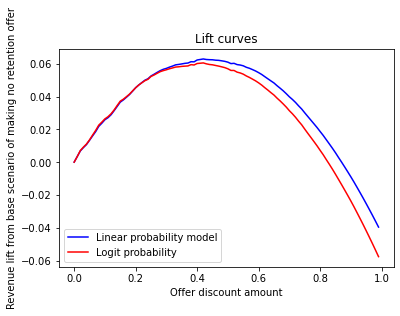

In [110]:

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

